# Relationship between EV Ownership and Economic Means
Explore the relationship between EV ownership and median income as a marker of economic means. 

Population data [source](https://data.census.gov/cedsci/table?q=demographics&g=0400000US53,53.860000&tid=ACSDP5Y2019.DP05&hidePreview=true)

Income data [source](https://data.census.gov/cedsci/table?q=income&g=0400000US53,53.860000&tid=ACSST5Y2019.S1903&hidePreview=true)

In [1]:
# Plotting latitude and longitude of each registered vehicle / charging station on a map
# https://nbviewer.jupyter.org/github/ThibautBremand/Coursera_Capstone/blob/master/1-Toronto_Clustering_By_Venues_Categories.ipynb

# import the basics
import numpy as np
import pandas as pd
import re
import missingno as msno

# plotting-related imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# import matplotlib
# matplotlib.style.use('ggplot')

# mapping-related imports
import folium
import requests
import geocoder # import geocoder
import branca

from datetime import datetime
# Import time series modeling tools (ARIMA, Prophet)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# import tools for model evaluation
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# settings to view full dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Importing plotly failed. Interactive plots will not work.


In [2]:
# EV Ownership
map_title = pd.read_csv('./Data/map_title.csv')

### Population

In [3]:
# function to keep just the zipcode and not extra text
def split_zip(row):
    return row.split()[-1]

In [4]:
popln = pd.read_csv('./Data/WA_popln_ACS.csv')

# pick out zipcode and median income
popln = popln[['NAME','DP05_0001E']]

# rename columns, drop extras
popln.columns = ['zip','total_pop']
popln = popln.drop([0,599])

# apply function to zipcode
popln['zip'] = popln['zip'].apply(split_zip)

# replace extraneous, set type, reset index, sort
popln.replace('-',None, inplace=True)
popln = popln.astype({'zip': 'int32', 'total_pop': 'int32'})
popln.reset_index(inplace=True, drop=True)
popln.sort_values(by='zip', inplace=True)
print(popln.shape)
popln.head()

(598, 2)


,zip,total_pop
0,98001,33699
1,98002,33468
2,98003,49533
3,98004,36202
4,98005,19223


### Income info

In [5]:
income = pd.read_csv('./Data/WA_income_ACS.csv')

# pick out zipcode and median income
income = income[['NAME','S1903_C03_001E']]

# rename columns, drop extras
income.columns = ['zip','median']
income = income.drop([0,599])



# apply function to zipcode
income['zip'] = income['zip'].apply(split_zip)

# replace extraneous, set type, reset index, sort
income.replace('-',None, inplace=True)
income = income.astype({'zip': 'int32', 'median': 'int32'})
income.reset_index(inplace=True, drop=True)
income.sort_values(by='zip', inplace=True)
print(income.shape)
income.head()

(598, 2)


,zip,median
0,98001,90287
1,98002,57317
2,98003,59391
3,98004,134580
4,98005,120913


In [6]:
popln_income = pd.merge(popln, income, on="zip")
popln_income.head()

,zip,total_pop,median
0,98001,33699,90287
1,98002,33468,57317
2,98003,49533,59391
3,98004,36202,134580
4,98005,19223,120913


In [7]:
# uncomment to save
# popln_income.to_csv('./Data/popln_income.csv', index=False)

In [8]:
# popln_income = pd.read_csv('./Data/popln_income.csv')

In [9]:
# merge EV data with population/income
ev_pop_inc = pd.merge(map_title, popln_income, left_on=  ['zip'],
                   right_on= ['zip'], 
                   how = 'left')
ev_pop_inc.head(2)

,vehicle_type,vin,model_year,make,model,new_or_used_vehicle,sale_price,dol_transaction_date,transaction_type,transaction_year,electric_vehicle_fee_paid,county,city,zip,electric_range,base_msrp,2015_hb_2778_exemption_eligibility,sale_date,vehicle_primary_use,state_of_residence,dol_vehicle_id,legislative_district,2019_hb_2042_clean_alternative_fuel_vehicle_(cafv)_eligibility,meets_2019_hb_2042_electric_range_requirement,meets_2019_hb_2042_sale_date_requirement,meets_2019_hb_2042_sale_price/value_requirement,odometer_reading,odometer_code,transportation_electrification_fee_paid,hybrid_vehicle_electrification_fee_paid,lat,lng,total_pop,median
0,Battery Electric Vehicle (BEV),1N4AZ0CP5E,2014,NISSAN,LEAF,Used,8403,May 04 2017,Transfer Title,2017,Not Applicable,Whatcom,BELLINGHAM,98225,84,28980.0,TRANSACTION NOT ELIGIBLE: Not a new vehicle,February 28 2017,Passenger,WA,210160730,42.0,TRANSACTION NOT ELIGIBLE: Sale before August 2019,True,False,True,17979,Actual Mileage,Not Applicable,Not Applicable,48.750940,-122.501286,51697.0,50184.0
1,Battery Electric Vehicle (BEV),1N4AZ0CP1D,2013,NISSAN,LEAF,Used,12312016,January 23 2017,Transfer Title,2017,Not Applicable,King,SHORELINE,98155,75,28800.0,TRANSACTION NOT ELIGIBLE: Not a new vehicle,December 31 2016,Passenger,WA,221188747,32.0,TRANSACTION NOT ELIGIBLE: Sale before August 2019; TRANSACTION NOT ELIGIBLE: Sale price too high,True,False,False,27738,Actual Mileage,Not Applicable,Not Applicable,47.754413,-122.300477,35041.0,94054.0


In [10]:
# look for null values
ev_pop_inc['median'].isnull().sum()

4

In [11]:
# check state of residence
ev_pop_inc['state_of_residence'].value_counts()

WA    110159
OR         4
Name: state_of_residence, dtype: int64

With 4 entries with null median income (owners live in Oregon), drop these.

In [12]:
# pick out columns of interest
ev_cols = ['zip','county','city','vehicle_type','model_year','make','model','new_or_used_vehicle','sale_price','dol_transaction_date',
           'transaction_type','transaction_year','electric_range','base_msrp','sale_date',
          'dol_vehicle_id','lat','lng','total_pop','median']
ev_subset = ev_pop_inc[ev_cols].copy()

In [13]:
# convert to datetime
ev_subset['dol_transaction_date'] = pd.to_datetime(ev_subset.loc[:,'dol_transaction_date'])

ev_subset[['model_year','sale_price','electric_range','base_msrp','median']].describe()

,model_year,sale_price,electric_range,base_msrp,median
count,110163.000000,1.101630e+05,110163.000000,110163.000000,110159.000000
mean,2016.431361,2.944299e+04,132.488376,41156.647745,97238.568415
std,2.593590,4.802248e+04,95.565446,17412.509480,31895.274287
min,1993.000000,0.000000e+00,6.000000,0.000000,18750.000000
25%,2014.000000,0.000000e+00,53.000000,30433.590308,71918.000000
50%,2017.000000,2.669800e+04,84.000000,35000.000000,94054.000000
75%,2018.000000,4.809250e+04,215.000000,41350.000000,117704.000000
max,2021.000000,1.231202e+07,390.000000,845000.000000,212337.000000


### Correlations

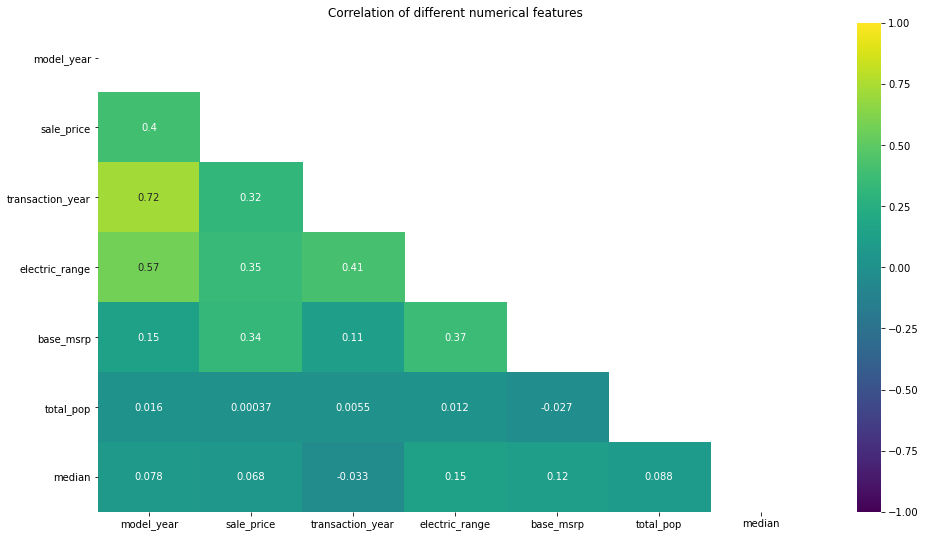

In [14]:
# heatmap
features = ['model_year', 'sale_price', 'transaction_year',
           'electric_range','base_msrp','total_pop','median']
ev_corr = ev_subset[features]

plt.figure(figsize=(16,9))
corr=ev_corr.corr()

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
g=sns.heatmap(corr,annot=True,cmap='viridis',vmin=-1,vmax=1,mask=mask)
plt.title('Correlation of different numerical features')
plt.show()

Strongest correlations:
* Transaction year and model year - people buy the most recent model
* Model year and electric range - range increases with time as battery technology improves
* Model year and sale price - price increases each year

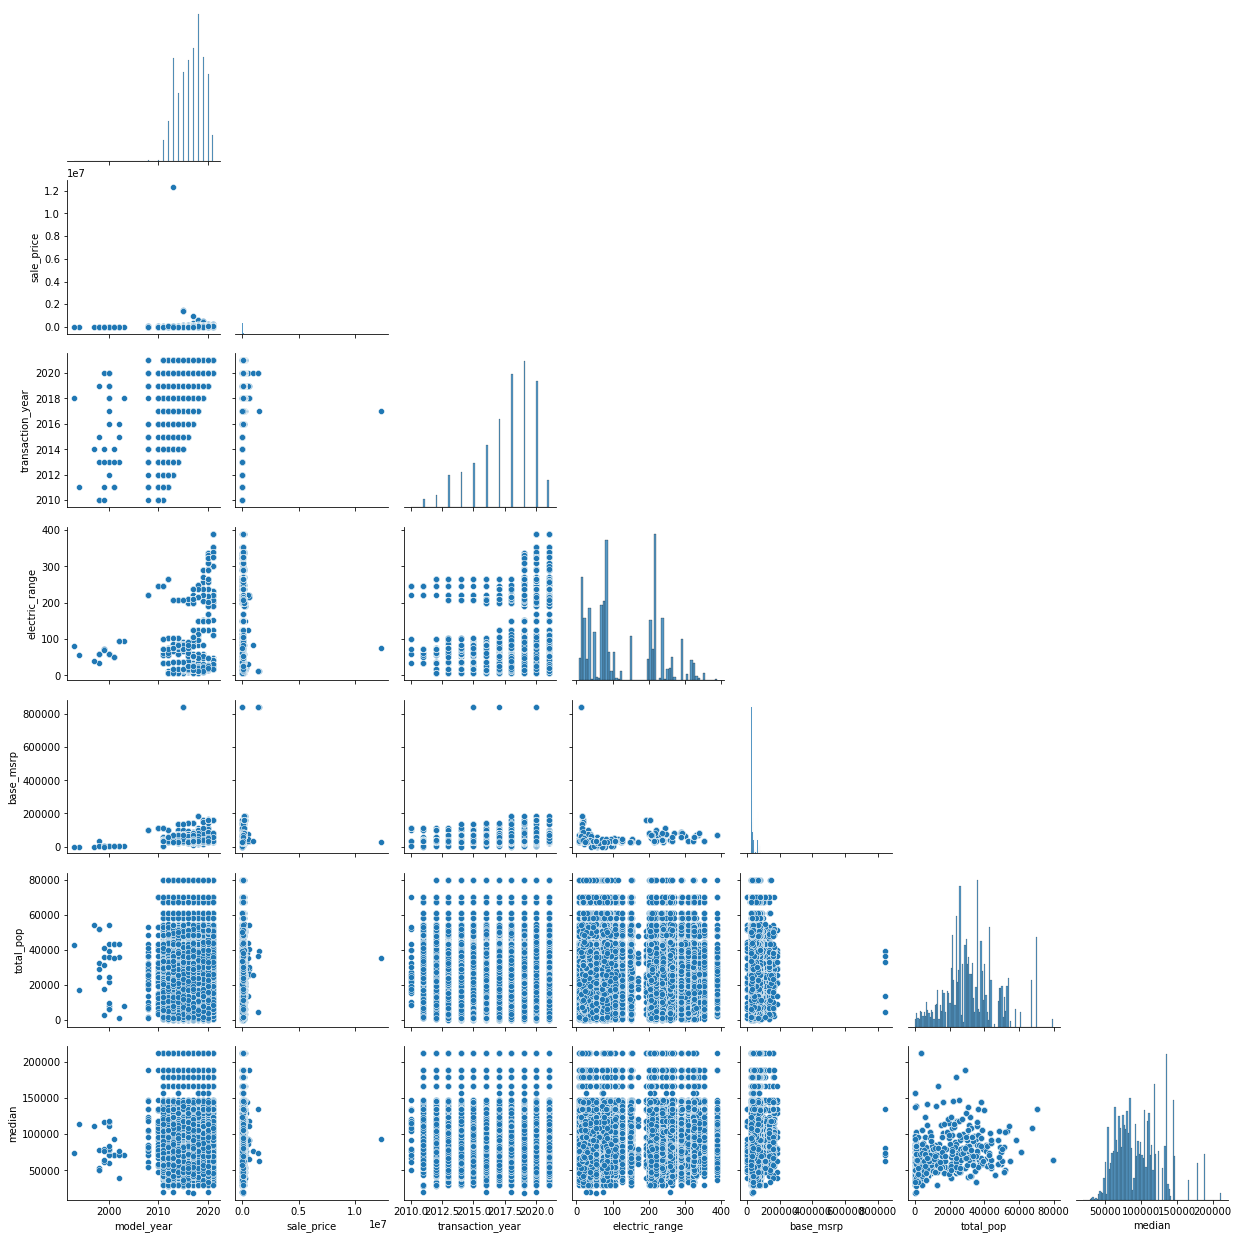

In [15]:
# correlation plot
sns.pairplot(ev_corr, corner=True)
plt.show()

### Parse Median Income

In [16]:
# create column labeling above-median zipcodes and below-median zipcodes
med_median = 74073 # Washington State household median income (https://datausa.io/profile/geo/washington)
ev_subset['above_med'] = [1 if val > med_median else 0 for val in ev_subset['median']]
ev_subset.head(2)

,zip,county,city,vehicle_type,model_year,make,model,new_or_used_vehicle,sale_price,dol_transaction_date,transaction_type,transaction_year,electric_range,base_msrp,sale_date,dol_vehicle_id,lat,lng,total_pop,median,above_med
0,98225,Whatcom,BELLINGHAM,Battery Electric Vehicle (BEV),2014,NISSAN,LEAF,Used,8403,2017-05-04,Transfer Title,2017,84,28980.0,February 28 2017,210160730,48.750940,-122.501286,51697.0,50184.0,0
1,98155,King,SHORELINE,Battery Electric Vehicle (BEV),2013,NISSAN,LEAF,Used,12312016,2017-01-23,Transfer Title,2017,75,28800.0,December 31 2016,221188747,47.754413,-122.300477,35041.0,94054.0,1


In [17]:
# how do EVs split with income
ev_subset['above_med'].value_counts(normalize=True)

1    0.727885
0    0.272115
Name: above_med, dtype: float64

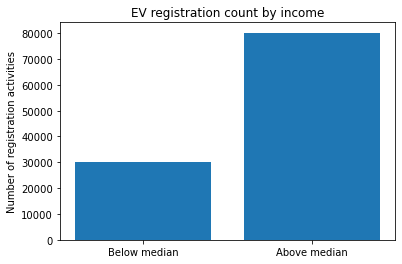

In [18]:
# visualize
valcts = ev_subset['above_med'].value_counts()

plt.bar(valcts.index,valcts)
plt.title('EV registration count by income')
x = [0,1]
plt.xticks(x, ['Below median','Above median'])
plt.ylabel('Number of registration activities')
plt.show()

72.8% of EV registrations in WA state were carried out in zip codes with median income above the state median income.

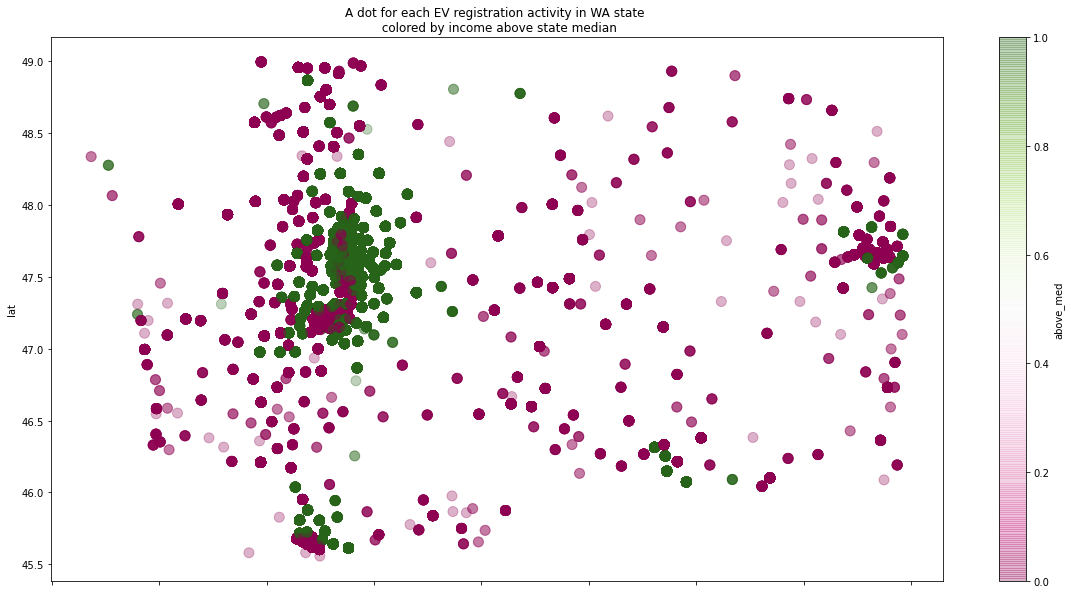

In [19]:
# visualize on x-y scatter plot
ev_subset.plot(kind="scatter", x="lng", y="lat", c="above_med",
         cmap="PiYG", figsize=(20, 10), s=100, alpha=0.3);
plt.title('A dot for each EV registration activity in WA state \n colored by income above state median')
plt.show()

Prep for visualization on folium.

In [20]:
# Reference for plotting latitude and longitude of each registered vehicle / charging station on a folium map
# https://nbviewer.jupyter.org/github/ThibautBremand/Coursera_Capstone/blob/master/1-Toronto_Clustering_By_Venues_Categories.ipynb

In [21]:
# create df with zip, lat, lng
ev_zip_latlng = ev_subset[['zip','lat','lng','above_med']]
ev_zip_latlng.drop_duplicates(subset = ['lat','lng'],inplace=True)
ev_zip_latlng.head()

<ipython-input-21-7b5d8ec650b7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_zip_latlng.drop_duplicates(subset = ['lat','lng'],inplace=True)


,zip,lat,lng,above_med
0,98225,48.750940,-122.501286,0
1,98155,47.754413,-122.300477,1
2,98826,47.783145,-120.843168,0
3,98513,46.977030,-122.733942,1
4,98340,47.910095,-122.571060,0


In [22]:
# count vehicles in each zip, then merge with lat, lng
ev_by_zip = ev_subset[['zip','model']].groupby(by='zip').count()
ev_by_zip.reset_index(inplace=True)
ev_by_zip = pd.merge(ev_by_zip, ev_zip_latlng, left_on = ['zip'],
                   right_on = ['zip'], 
                   how = 'left')

ev_by_zip.head()

,zip,model,lat,lng,above_med
0,97053,1,45.827979,-122.883286,0
1,97116,1,45.580822,-123.165693,0
2,97211,1,45.581132,-122.637305,0
3,97230,1,45.557757,-122.505268,0
4,98001,413,47.310617,-122.263291,1


In [23]:
# referenced this for folium: https://www.google.com/url?q=https://nbviewer.jupyter.org/github/ThibautBremand/Coursera_Capstone/blob/master/1-Toronto_Clustering_By_Venues_Categories.ipynb&sa=D&source=editors&ust=1618488051134000&usg=AFQjCNE_3Vf3-Uy6y6eHUiUF8iBE2q7M6g
# find the coordinate for the center of WA state
# initialize to None
lat_lng_coords = None

# loop until we get the coordinates
while(lat_lng_coords is None):
    g = geocoder.arcgis('Ellensburg, Washington') # I want the WA map to be centered on the middle of WA state
    lat_lng_coords = g.latlng

latitude_wa = lat_lng_coords[0]
longitude_wa = lat_lng_coords[1]

print('The geograpical coordinate of Ellensburg, WA are {}, {}.'.format(latitude_wa, longitude_wa))

The geograpical coordinate of Ellensburg, WA are 46.99703000000005, -120.54871999999995.


Circle for each zipcode, colored by 'above_med'.

In [24]:
map_wa = folium.Map(width=1000, height=700,location=[latitude_wa, longitude_wa], zoom_start=7)

circle_color = ['red','blue']

for ind in range(ev_by_zip.shape[0]):
    lat = ev_by_zip.loc[ind,'lat']
    lng = ev_by_zip.loc[ind,'lng']
    color_val = ev_by_zip.loc[ind,'above_med']
    
    folium.CircleMarker(
    [lat,lng],
#     radius = ev_by_zip.loc[ind,'model']/70,
    radius = 5,
    color=circle_color[color_val],
    fill=True,
    fill_color=circle_color[color_val],
    fill_opacity=0.5).add_to(map_wa)

# legend for color. Though this implementation is suboptimal since my circles only have 2 colors instead of a gradation
# https://stackoverflow.com/questions/52911688/python-folium-choropleth-map-colors-incorrect/52981115#52981115
# https://stackoverflow.com/questions/47846744/create-an-asymmetric-colormap

colormap = branca.colormap.LinearColormap(colors=['red','blue'], index=[0,1],vmin=0,vmax=1)
colormap.caption = 'Zipcode median income relative to state median income'
colormap.add_to(map_wa)

map_wa

### Vehicle type by median income class

In [25]:
above_med_pt = pd.pivot_table(ev_subset,index=['above_med','vehicle_type'],values=['dol_vehicle_id'],aggfunc=[len])
above_med_pt

len
                                                 dol_vehicle_id
above_med vehicle_type                                         
0         Battery Electric Vehicle (BEV)                  18927
          Plug-in Hybrid Electric Vehicle (PHEV)          11050
1         Battery Electric Vehicle (BEV)                  59041
          Plug-in Hybrid Electric Vehicle (PHEV)          21145

<ipython-input-26-24817fc30de6>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels=xlabels)
<ipython-input-26-24817fc30de6>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=xlabels)


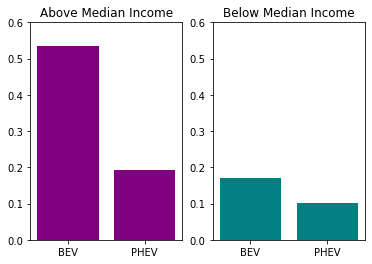

In [26]:
# plot as a bar graph of percentage

above_med = ev_subset[ev_subset['above_med']==1]['vehicle_type'].value_counts()/ev_subset.shape[0]
below_med = ev_subset[ev_subset['above_med']==0]['vehicle_type'].value_counts()/ev_subset.shape[0]

xlabels = ['BEV','PHEV']
fig,ax=plt.subplots(1,2)
ax[0].bar(above_med.index,above_med,color='purple')
ax[0].set_xticklabels(labels=xlabels)
ax[0].set_ylim(0,0.6)
ax[0].set_title('Above Median Income')

ax[1].bar(below_med.index,below_med,color='teal')
ax[1].set_xticklabels(labels=xlabels)
ax[1].set_ylim(0,0.6)
ax[1].set_title('Below Median Income')
plt.show()

For both above- and below-median income groups, BEV ownership constitutes a higher percentage of total EV ownership.

We can set up a Bayes-theorem question here:

What is the probability that someone living in a below-median income zipcode has a BEV?

P(BEV|Low) = (P(Low|BEV) * P(BEV)) / P(Low)

P(BEV|Low) = (0.25 * 0.72) / 0.27

P(BEV|Low) = 0.7

This makes sense looking at the Below Median Income bar graph above where BEV constitutes 70% of total within the below-median-income group.

### Ownership transfer of vehicles (used cars)
* Does ownership go from high median income zip to low median income zip from 1st purchase to resale?
* Does ownership keep going down the income level over time?

In [27]:
# 1000 vehicles that have been bought and sold the most times
resale = ev_subset['dol_vehicle_id'].value_counts(ascending=False)[:1000]

col_names = ['zip','vehicle_type','make','model','model_year','dol_transaction_date','transaction_year','sale_price','median','dol_vehicle_id']
used_car = pd.DataFrame(columns=col_names)

for dol in list(resale.index):
    used_car = used_car.append(ev_subset[ev_subset['dol_vehicle_id']==dol][col_names])

In [28]:
used_car_table = pd.pivot_table(used_car,index=['dol_vehicle_id','make','model','model_year','vehicle_type'],values=['dol_transaction_date'],aggfunc=[len]).sort_values(by='make')
used_car_table

,,,,,len
,,,,,dol_transaction_date
dol_vehicle_id,make,model,model_year,vehicle_type,
330993645,AUDI,A3 E-TRON,2018,Plug-in Hybrid Electric Vehicle (PHEV),3
474361401,AUDI,A3 E-TRON,2018,Plug-in Hybrid Electric Vehicle (PHEV),3
289338290,AUDI,A3 E-TRON,2016,Plug-in Hybrid Electric Vehicle (PHEV),3
135080935,AUDI,A3 E-TRON,2016,Plug-in Hybrid Electric Vehicle (PHEV),3
169279939,AUDI,A3 E-TRON,2016,Plug-in Hybrid Electric Vehicle (PHEV),4
...,...,...,...,...,...
329819745,VOLKSWAGEN,E-GOLF,2015,Battery Electric Vehicle (BEV),4
250310287,VOLKSWAGEN,E-GOLF,2015,Battery Electric Vehicle (BEV),3


In [29]:
# convert pivot table to dataframe and sort by count
# https://stackoverflow.com/questions/43756052/transform-pandas-pivot-table-to-regular-dataframe

used_car_table.columns = used_car_table.columns.droplevel(0) # remove len, dol_transaction_date
used_car_table.columns.name = None # remove categories
used_car_table = used_car_table.reset_index()
used_car_table.rename(columns={'dol_transaction_date':'count'}, inplace=True)

In [30]:
# now back to being a dataframe
used_car_table = used_car_table.sort_values(by='count',ascending=False)
used_car_table.head()

,dol_vehicle_id,make,model,model_year,vehicle_type,count
592,123232007,NISSAN,LEAF,2011,Battery Electric Vehicle (BEV),8
581,242274084,NISSAN,LEAF,2012,Battery Electric Vehicle (BEV),7
709,165508192,NISSAN,LEAF,2011,Battery Electric Vehicle (BEV),7
478,222873906,NISSAN,LEAF,2011,Battery Electric Vehicle (BEV),6
808,204897892,NISSAN,LEAF,2013,Battery Electric Vehicle (BEV),6


In [31]:
used_car_table['model'].value_counts(normalize=True)[:10]

LEAF             0.490
VOLT             0.134
MODEL S          0.078
I3               0.065
FUSION ENERGI    0.053
C-MAX ENERGI     0.036
FOCUS            0.020
PRIUS            0.020
MODEL 3          0.012
500E             0.012
Name: model, dtype: float64

50% of the top 1000 most resold vehicles is a Nissan Leaf (BEV). At 1/3 the volume is the Chevy Volt (PHEV).

In [32]:
used_car.dropna(inplace=True) # drop 1 null value
used_car[['zip','model_year','transaction_year','median']] = used_car[['zip','model_year','transaction_year','median']].astype(int)

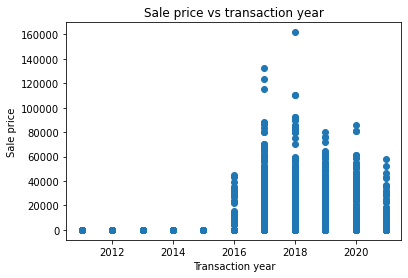

In [33]:
plt.scatter(used_car['transaction_year'],used_car['sale_price'])
plt.xlabel('Transaction year')
plt.ylabel('Sale price')
plt.title('Sale price vs transaction year')
plt.show()

In [34]:
used_car[used_car['sale_price']==0].shape[0]/used_car.shape[0]

0.46147880041365047

A good 46% of vehicles resold do not have a sale price attached to the records. It's more likely that it was not recorded / not disclosed, than that the price was actually 0. Will want to replace these with NaN at some point, to calculate averages.

In [35]:
used_car.head()

,zip,vehicle_type,make,model,model_year,dol_transaction_date,transaction_year,sale_price,median,dol_vehicle_id
17409,98188,Battery Electric Vehicle (BEV),NISSAN,LEAF,2011,2016-07-19,2016,0,60586,123232007
24799,98188,Battery Electric Vehicle (BEV),NISSAN,LEAF,2011,2018-04-11,2018,0,60586,123232007
30500,98208,Battery Electric Vehicle (BEV),NISSAN,LEAF,2011,2020-09-14,2020,4000,91574,123232007
33938,98148,Battery Electric Vehicle (BEV),NISSAN,LEAF,2011,2015-06-10,2015,0,61455,123232007
46972,98208,Battery Electric Vehicle (BEV),NISSAN,LEAF,2011,2019-12-26,2019,7900,91574,123232007


#### Median income with EV resale

In [36]:
# in order to plot median income with each resale, first extract the registrations for each vehicle ID, sort, and put into a dictionary
# then turn that dictionary into a dataframe

# instantiate empty dictionary
reuse_dict = {}

# for each vehicle ID, pull out the registration events, sort, and put into a dictionary
for dol in list(resale.index):
    each_car = used_car[used_car['dol_vehicle_id']==dol].sort_values(by='transaction_year')
    car_median = list(each_car['median'])
    under8 = 8 - len(car_median) # longest resale sequence is 8
    median_list = car_median + [None]*under8 # fill up with 'None' if resale sequence is less than 8
    reuse_dict[dol] = median_list

In [37]:
# convert dictionary to dataframe
reuse_median = pd.DataFrame(reuse_dict)
reuse_median.head()

,123232007,165508192,242274084,104539179,195193113,250801750,167397016,127418469,146745910,232015899,236243094,2735638,206707126,246858615,204897892,229594501,242722679,250588110,222873906,275783938,245524527,349576888,347100029,166554342,201579367,186304058,142718390,217813207,177139651,147856726,347923089,222080204,264209529,183310172,194184700,232217639,192012362,110117962,184853861,113246192,218507488,143758114,269120995,226094277,235571920,280877628,171307125,115319144,2854400,111214561,200473899,185323862,349599295,201294509,136150430,151179745,4965649,168161542,203706037,190357044,241249536,182421018,302766978,105730201,179996911,4180627,176381663,201674077,232897731,214377971,141854205,200926302,236686957,130102885,6039365,126037481,148246157,397540,141032090,213614187,160232145,208492525,245257904,112135810,165569855,152060618,161057585,245759111,250279326,210669217,240820597,289325690,244789002,143209629,237852884,252985428,289317115,249488431,128505401,209259634,143928186,161276902,210937919,240366227,216245599,161345698,117680643,124692529,117590497,244279577,335909115,165321355,200169294,145248596,207986579,144397613,46112,6518704,142805351,141356687,128174098,100311431,165415834,103165590,169847800,146128482,226764387,112010335,240859160,241034692,160252809,266644150,198609876,278642710,124045288,113789868,207681260,191806198,156822949,201940378,257494443,206544922,268899746,140627112,164460404,207801492,196121985,114300042,475454710,214512931,256615488,172994993,138640694,161512389,230905013,256453704,261530825,246734022,275876681,201492189,241112455,230853479,197229994,237956484,349275993,222621283,248501417,151056244,242258712,207494563,216073917,163194797,180610321,208707677,250753541,224893168,229025289,244098809,192556045,187145465,151282113,154490080,7439477,226579174,193901788,144132593,140398744,9196890,183693303,173536443,190131924,280293219,5915857,263782340,249107855,246434058,117638573,125339406,9556578,100783581,122695149,106800809,179776250,187669576,259121621,196736900,184190590,239976691,117522219,231263896,165955289,207594768,149123376,145131738,184860784,106785206,9343302,138028551,142240136,176148619,126273696,212237665,107227725,289346627,275717389,145390472,137185856,175594856,201958452,189458454,226242684,1481000,181487603,233280323,194820370,169785101,190643813,136226352,325017892,283567672,179689646,143193613,149120352,150708813,227639212,198712825,228958019,254155415,204024173,198191612,6688692,215842497,199356853,234022834,161956259,135911030,1333454,174327436,161251247,150512491,124077040,196761316,152699025,167014249,132301053,155060216,180416869,125608122,857237,139863664,215982238,115797783,233838545,136784308,266066517,138298632,194736181,190526024,198244763,207358896,150851515,129600313,270314250,238630878,293273998,347772687,184246303,114436346,107461490,265306359,115807702,109254925,203079215,348690107,110596986,131724806,27702,3778883,240025502,139612476,229359504,175505438,277457883,4192562,5093308,251929023,223492426,156969620,113239836,116223054,215157456,146381182,224412352,235911203,198602778,1473223,180561804,123384593,248175315,234054516,198060852,130630342,223568943,198036296,161537421,103007747,346667870,215018163,126271652,227099512,223809904,206674478,246397322,259891110,104078082,110860319,137603056,137554336,126071760,220119147,256302077,176445685,149674332,184650224,4185800,150759920,151461768,474344188,134141766,242237292,125739239,9387073,2513430,162181204,266238248,250221016,158751785,103736090,206402696,112159883,186456959,146710084,268936230,253826261,206296408,103679922,242529682,225623513,244430399,152280019,3741790,106513102,108884212,138952201,154937142,169819989,137500702,8493845,153303258,114634971,128816089,178460803,141347139,117227484,170522572,180337013,190493985,167815112,880071,165573152,133113578,121969333,142471073,182619643,121110846,158780611,176639550,230482171,199462896,268848520,251674244,157228578,167375260,218436333,176276215,219461756,22

In [38]:
# check on what .mean does
reuse_median.median(axis=1)

0    96545.0
1    84278.5
2    80196.0
3    79434.0
4    79434.0
5    84787.0
6    60586.0
7    91574.0
dtype: float64

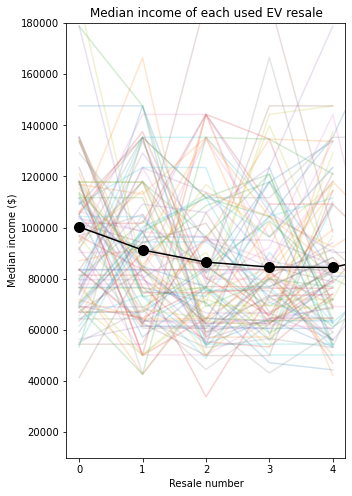

In [39]:
# plot median income with vehicle resale instance
plt.figure(figsize=(5,8))
plt.plot(reuse_median.index,reuse_median.iloc[:,:100],alpha=0.2)

# plot median of all incomes, for trend
plt.plot(reuse_median.index,reuse_median.mean(axis=1),color='black',linestyle='-',marker='o',ms=10)
plt.ylim([10000,180000])
x = range(8)
plt.xticks(x, ['0','1','2','3','4','5','6','7'])
plt.xlabel('Resale number')
plt.ylabel('Median income ($)')
plt.title('Median income of each used EV resale')
plt.xlim([-0.2,4.2])
plt.show()

#### Sale price with EV resale

In [40]:
# in order to plot median income with each resale, first extract the registrations for each vehicle ID, sort, and put into a dictionary
# then turn that dictionary into a dataframe

# instantiate empty dictionary
reuse_price = {}

# for each vehicle ID, pull out the registration events, sort, and put into a dictionary
for dol in list(resale.index):
    each_car = used_car[used_car['dol_vehicle_id']==dol].sort_values(by='transaction_year')
    car_price = list(each_car['sale_price'])
    under8 = 8 - len(car_price) # longest resale sequence is 8
    price_list = car_price + [None]*under8 # fill up with 'None' if resale sequence is less than 8
    reuse_price[dol] = price_list

In [41]:
# convert dictionary to dataframe
df_reuse_price = pd.DataFrame(reuse_price)
df_reuse_price.replace({0.0:None},inplace=True)
df_reuse_price.head()

,123232007,165508192,242274084,104539179,195193113,250801750,167397016,127418469,146745910,232015899,236243094,2735638,206707126,246858615,204897892,229594501,242722679,250588110,222873906,275783938,245524527,349576888,347100029,166554342,201579367,186304058,142718390,217813207,177139651,147856726,347923089,222080204,264209529,183310172,194184700,232217639,192012362,110117962,184853861,113246192,218507488,143758114,269120995,226094277,235571920,280877628,171307125,115319144,2854400,111214561,200473899,185323862,349599295,201294509,136150430,151179745,4965649,168161542,203706037,190357044,241249536,182421018,302766978,105730201,179996911,4180627,176381663,201674077,232897731,214377971,141854205,200926302,236686957,130102885,6039365,126037481,148246157,397540,141032090,213614187,160232145,208492525,245257904,112135810,165569855,152060618,161057585,245759111,250279326,210669217,240820597,289325690,244789002,143209629,237852884,252985428,289317115,249488431,128505401,209259634,143928186,161276902,210937919,240366227,216245599,161345698,117680643,124692529,117590497,244279577,335909115,165321355,200169294,145248596,207986579,144397613,46112,6518704,142805351,141356687,128174098,100311431,165415834,103165590,169847800,146128482,226764387,112010335,240859160,241034692,160252809,266644150,198609876,278642710,124045288,113789868,207681260,191806198,156822949,201940378,257494443,206544922,268899746,140627112,164460404,207801492,196121985,114300042,475454710,214512931,256615488,172994993,138640694,161512389,230905013,256453704,261530825,246734022,275876681,201492189,241112455,230853479,197229994,237956484,349275993,222621283,248501417,151056244,242258712,207494563,216073917,163194797,180610321,208707677,250753541,224893168,229025289,244098809,192556045,187145465,151282113,154490080,7439477,226579174,193901788,144132593,140398744,9196890,183693303,173536443,190131924,280293219,5915857,263782340,249107855,246434058,117638573,125339406,9556578,100783581,122695149,106800809,179776250,187669576,259121621,196736900,184190590,239976691,117522219,231263896,165955289,207594768,149123376,145131738,184860784,106785206,9343302,138028551,142240136,176148619,126273696,212237665,107227725,289346627,275717389,145390472,137185856,175594856,201958452,189458454,226242684,1481000,181487603,233280323,194820370,169785101,190643813,136226352,325017892,283567672,179689646,143193613,149120352,150708813,227639212,198712825,228958019,254155415,204024173,198191612,6688692,215842497,199356853,234022834,161956259,135911030,1333454,174327436,161251247,150512491,124077040,196761316,152699025,167014249,132301053,155060216,180416869,125608122,857237,139863664,215982238,115797783,233838545,136784308,266066517,138298632,194736181,190526024,198244763,207358896,150851515,129600313,270314250,238630878,293273998,347772687,184246303,114436346,107461490,265306359,115807702,109254925,203079215,348690107,110596986,131724806,27702,3778883,240025502,139612476,229359504,175505438,277457883,4192562,5093308,251929023,223492426,156969620,113239836,116223054,215157456,146381182,224412352,235911203,198602778,1473223,180561804,123384593,248175315,234054516,198060852,130630342,223568943,198036296,161537421,103007747,346667870,215018163,126271652,227099512,223809904,206674478,246397322,259891110,104078082,110860319,137603056,137554336,126071760,220119147,256302077,176445685,149674332,184650224,4185800,150759920,151461768,474344188,134141766,242237292,125739239,9387073,2513430,162181204,266238248,250221016,158751785,103736090,206402696,112159883,186456959,146710084,268936230,253826261,206296408,103679922,242529682,225623513,244430399,152280019,3741790,106513102,108884212,138952201,154937142,169819989,137500702,8493845,153303258,114634971,128816089,178460803,141347139,117227484,170522572,180337013,190493985,167815112,880071,165573152,133113578,121969333,142471073,182619643,121110846,158780611,176639550,230482171,199462896,268848520,251674244,157228578,167375260,218436333,176276215,219461756,22

In [42]:
# check on what .mean does
df_reuse_price.median(axis=1)

0    31040.0
1    15500.0
2    11516.5
3     8882.5
4     6500.0
5     6000.0
6     5200.0
7     4000.0
dtype: float64

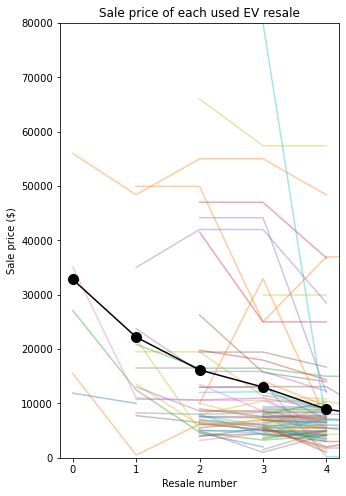

In [43]:
# plot median sale price with vehicle resale instance
plt.figure(figsize=(5,8))
plt.plot(df_reuse_price.index,df_reuse_price.iloc[:,:100],alpha=0.4)

# plot median of all sale prices, for trend
plt.plot(df_reuse_price.index,df_reuse_price.mean(axis=1),color='black',linestyle='-',marker='o',ms=10)
plt.ylim([0,80000])
x = range(8)
plt.xticks(x, ['0','1','2','3','4','5','6','7'])
plt.xlabel('Resale number')
plt.ylabel('Sale price ($)')
plt.title('Sale price of each used EV resale')
plt.xlim([-0.2,4.2])
plt.show()

With each resale, the EV goes from higher to lower median income zipcodes, and from higher to lower sale price. This bodes well for increased accessibility (price-wise), because EVs generally have lower maintenance costs due to much fewer moving parts, thought battery longevity issues will start to arise.

### Ownership growth by income

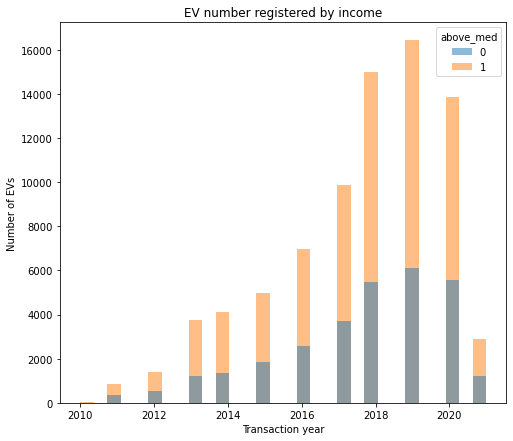

In [50]:
plt.figure(figsize=(8,7))
sns.histplot(data=ev_subset, x='transaction_year', hue='above_med', stat='count', edgecolor=None, bins=30)
plt.xlabel('Transaction year')
plt.ylabel('Number of EVs')
plt.title('EV number registered by income')
plt.show()

Ownership growth is faster among owners in above-median zipcodes compared to below-median zipcodes, though ownership continues to grow there too. This is a promising trend.